In [3]:
using Plots
pyplot()

Plots.PyPlotBackend()

# Lecture 7 part b - Computer simulations of Plasma Physics

**Christopher Brady and Heather Ratcliffe**

**Research Software Engineering / Physics**

## Overview

Computational plasma physics often involves large scale direct simulations. Direct simulation involves simulating low level equations that map directly to the underlying physics, rather than deriving simplified equations for a specific problem (such a looking at waves as we did in Part 1. To derive the waves you have to simplify the low level equations). This is very powerful and allows the simulation of arbitrary problems but is generally more computationally expensive. In this section we're going to very briefly introduce a type of code called the "Particle in Cell" or "PIC" simulation.

# Particle in Cell simulations

As we described earlier plasmas can be described in terms of charged particles moving in EM fields. So to simulate them fully you need

  1. Equations to describe the evolution of EM fields

  2. Equations to describe the force on a charged particle due to an EM field

  3. Equations to describe the electric current that moving charged particles create

There are actually several ways of doing this, but one of the most widely used is the "particle in cell" approach. This works by having charged particles (as in the name) that are free to move anywhere in the region of space being simulated. Space is also split up into "cells" with the EM fields being solved on a fixed lattice of cells.

# Simplications and 1.5D models

Full 3D EM (and plasma EM) simulations do happen, but they are the preserve of large high performance computer systems. A common simplification is to simulate what's called a *1.5D* system. That sounds odd, but all that it means is that it's a 1D system in some senses and not in others. Specifically

  1. All vector fields still have all 3 components (so there's still $E_x$, $E_y$ and $E_z$)

  2. All derivatives not in the x direction are 0.

For simplicity here, we're going to be even more specific. As already mentioned the fields in an EM wave are at 90 degrees to each other (in a vacuum at least). So fluctuations in $E_y$ only lead to fluctuations in $B_z$ and fluctuations in $E_z$ only lead to fluctuations in $B_y$. If you only have one wave you can always freely rotate your axes until your E field is pointing exactly along $E_y$. At which point, you only have to consider $E_y$ and $B_z$ which reduces the number of equations substantially.

# 1) Maxwell's equations

The equations that describe EM fields are called the **Maxwell Equations**. There are different versions of the Maxwell equations, but in 1.5D with only $E_y$ and $B_z$ components one of the simpler ones is

$$\frac{\partial E_x}{\partial x} = \frac{\rho}{\epsilon_0}$$

**Gauss's Law** describes how an arrangement of charged particles, described by the charge density $\rho$ will directly generate an electric field. Essentially this says that positive charge is a source of electric field and negative charge is a sink of electric field. It also says that there can be no other sources or sinks of electric field within a domain other than charges.

$$\frac{\partial B_x}{\partial x} = 0$$

**Gauss's Law for magnetism** says that magnetic field cannot be created directly, only converted from electric field. This is related to the fact that if you cut a magnet in two, you wind up with two magnets each with it's own north pole and south pole rather than a single north pole and a single south pole.

$$\frac{\partial E_y}{\partial x} = -\frac{\partial B_z}{\partial t}$$

**Faraday's law of induction** - Says how time changing magnetic field can generate an electric field (c.f. generators. You spin a magnet to get a time varying magnetic field and you get an electric field in your wire in response). Note that your electric field is at 90 degrees to your magnetic field ($B_z$ generates $E_y$)

$$\frac{\partial B_z}{\partial x} = -\frac{1}{c^2}\frac{\partial E_y}{\partial t} + \mu_0 J_y$$

**Ampere's circuital law** says how a time varying electric field can generate a magnetic field, and how an electric current ($\mathbf{J}$) can also generate an electric field. Numerically $c$, the speed of light, is often set to 1. Note again the 90 degree shift between the electric and magnetic fields and note also that an electric current is in the direction as the electric field that it affects

# 2) Equations of particle motion

The equation that defines the motion of a particle in general is just Newton's equations of motion

$$\mathbf{F} = m\mathbf{a}\\
\mathbf{v} = \int_0^t \mathbf{a} dt\\
\mathbf{x} = \int_0^t \mathbf{v} dt$$

(if the particle is going fast enough then you have to include relativity, but we'll gloss over that here). So all that you need is an expression for the force on a charged particle in an EM field. This force is called the *Lorentz force* and is defined as

$$F_\mathrm{Lorentz} = q(\mathbf{E} + \mathbf{F_\mathrm{mag}})$$

where $q$ is the charge on a particle, $\mathbf{E}$ is the electric field and $\mathbf{F_\mathrm{mag}}$ is the force on a particle due to the magnetic field. The force due to $\mathbf{E}$ is simply in the direction that it points in. Thus an electric field accelerates a particle in the direction that the field points in. The magnetic force is more interesting because it is always perpendicular to both the direction of the magnetic field and the velocity of the charged particle. If you are familiar with vector cross products then strictly $\mathbf{F_\mathrm{mag}} = \mathbf{v} \times \mathbf{B}$. In our simplified system this becomes

$$F_\mathrm{{mag}_x} = v_y B_z\\
F_\mathrm{{mag}_y} = -v_x B_z\\
F_\mathrm{{mag}_z} = 0$$

This means that we only need to keep track of two components of the particle's velocity since there is no force in the Z direction from either the electric field or the magnetic field.

The fact that the force is both perpendicular to the current velocity and the direction of the magnetic field means that particles tend to move along magnetic field lines in spirals. Interestingly the form of this equation also means that a magnetic field can't change the energy of a particle only change its direction.

# 3) Current

The current due to a set of moving charges is just $\mathbf{J} = n q \mathbf{v}$. Where $\mathbf{J}$ is the current density, $n$ is the number density of the moving charges and $\mathbf{v}$ is the velocity of the charges. We're not actually going to get to doing this here, but to calculate the current, you can just sum up the $q \mathbf{v}$ for each particle.

# Final simplifications

There are a few further simplification that we can make. You'll notice that only two of Maxwell's equations include explicit time derivatives ($\partial / \partial t$). The other two are purely given in terms of the spatial derivative operators. That means that we can ignore those equations except when initially setting up our system. So long as our initial conditions satisfy them our answer will always satisfy them as we go forward in time. (Actually, numerically you could give an entire lecture course on making sure that this is true when you try to actually solve these equations, but you can do it).

We also ignore the back reaction of the particles on the fields so $\mathbf{J}$ is zero

And for the very final simplification, we do use $c = 1$

With these simplifications in place, we can write out the final equations that we need. First just for EM waves, and then for a plasma particle in an EM wave

# EM solver

The equations for the EM solver are now

$$\frac{\partial B_z}{\partial t} = \frac{\partial E_y}{\partial x}\\
 \frac{\partial E_y}{\partial t} = \frac{\partial B_z}{\partial x}$$
 
You can then use an integrator very like the Euler integrator that you've already seen to calculate both the time and space derivatives in these equations and solve for an EM wave. There are some very important differences, but they're too subtle to go into in this lecture (see https://en.wikipedia.org/wiki/Finite-difference_time-domain_method for details). In brief they are

#### Space derivatives
You calculate E field gradients using Ey[j+1] - Ey[j], but B using Bz[j]-Bz[j-1]. This is because E and B are not defined at quite the same point in space. (see https://upload.wikimedia.org/wikipedia/commons/1/1b/FDTD_Yee_grid_2d-3d.svg, they use $H$ instead of $B$, but the idea is the same). This is done for reasons of keeping the algorithm *stable*, i.e. ensuring that it gives the right answer rather than blowing up to insane values (try switching the two bits updating E to use E[j] - E[j-1] instead and you'll see that the answer becomes nonsense). Proving this requires the an understanding of numerical analysis, so we'll skip it here.

#### Time derivatives

In this type of code, we often talk about *timesteps*. That is the interval of time between $t$ (the current time) and $t + \Delta t$ (the time that we're trying to get the simulation to). I'll also mention a *half timestep* which is just the time $t + \frac{\Delta t}{2}$. For this EM simulation, we have the following algorithm

 1. You first advance B in time by $\Delta t/2$ using E at the start of the current step

 2. You then time integrate E by $\Delta t$ using B you just calculated in 1)

 3. You then time integrate B by another $\Delta t/2$ using E as calculated in 2). This brings B to the same point in time as E

The reasons for this are a bit simpler although still really beyond this lecture. Effectively what you're doing is calculating the value to integrate over at the centre of the integration period rather than at the start (when updating E you literally have B at the middle of the timestep from your first integration of B, and for B you are using an average of E at the start and the end of the timestep, so effectively in the middle). This is essentially equivalent to using the trapezium rule for integration rather than using the rectangle rule. This is explained a little more a bit further on.

An example of the algorithm is given below


In [8]:
#Set up parameters
nx = 400 #Number of grid points
L = 20.0 # Length of simulation domain
t_end = 15.0 # Time to end the simulation at

# Calculate spatial grid step
dx = L/Float64(nx+2)
x = linspace(0,nx+2,nx+2);
x = x .* dx

#Calculate the number of timesteps needed to obtain the required end time
#Note that because this scales as dx (and hence number of gridpoints) the whole code
#Scales as dx^2
dt = dx
nsnap = round(Int32, t_end/dt)

#Create arrays
Ey=zeros(nx+2)
Ey[:]=0.0
Bz=zeros(nx+2)
Bz[:] = 0.0

#Time starts at 0
time = 0.0

#Loop for enough cycles to reach the end of the simulation
for i in 1:nsnap
    
    #Update the magnetic field by half a timestep
    for j in 2:nx+1
        Bz[j] = Bz[j] - dt/2.0 * (Ey[j+1]-Ey[j])/dx
    end
    Bz[1] = sin(time) # Drive the boundary with a sine wave
    Bz[nx+2] = Bz[nx+1] #Set the outer boundary to be continuous. Prevent sharp gradients
    
    #Update the electric field by a full timestep
    for j in 2:nx+1
        Ey[j] = Ey[j] - dt * (Bz[j]-Bz[j-1])/dx
    end
    Ey[1] = Ey[2] #Set the outer boundary on both edges to be continuous
    Ey[nx+2] = Ey[nx+1]

    #Update the magnetic field by the other half timestep
    for j in 2:nx+1
        Bz[j] = Bz[j] - dt/2.0 * (Ey[j+1]-Ey[j])/dx
    end
    Bz[1] = sin(time) #Driver again
    Bz[nx+2] = Bz[nx+1]
    
    time = time + dt
end

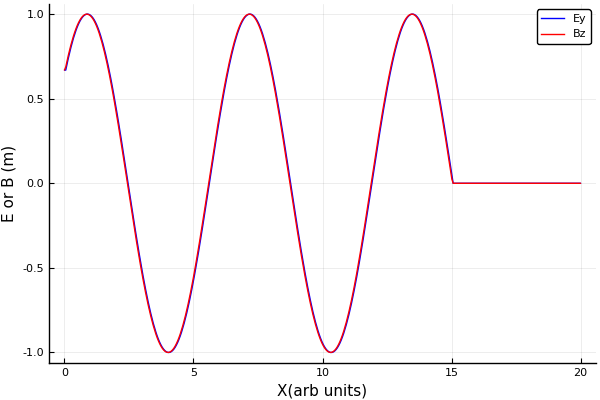

In [9]:
#Plot the answers
using Plots
pyplot()

plot(x, Ey, c=:blue, label="Ey", xlab="X(arb units)", ylab ="E or B (m)")
plot!(x, Bz, c=:red, label="Bz")

# Particle simulation

Adding a single particle to the simulation isn't very hard at all. Because of the structure of the Lorentz force, you have to keep track of two velocities for the particle, $v_x$ in the x direction and $v_y$ in the y direction. You don't need to keep track of $v_z$ because there is no $E_z$ to accelerate the particle in that direction, and for the magnetic field to bend it in that direction through the magnetic force you would need either $E_yB_x$ or $E_xB_y$ to be non-zero which doesn't happen here.

You only need to keep track of the $x$ position of the particle though. In 1.5D modelling, it is assumed that everything is uniform and infinite in the $y$ and $z$ directions, so while you _can_ keep track of the particle's $y$ position (since it does have a $y$ velocity this will be changing in time) you don't use it anywhere in the calculations.

You have to perform two integrations, first you have to integrate acceleration to get velocity and then you have to integrate velocity to get position. This is simple enough, but there are two things to worry about

### Second order integration
In order to get acceptable performance from these codes everything has to be done using the more accurate "time centred" or "second order" integrators. For the fields, this slightly changes the sequence above. Rather than doing half of the B update, then all of the E update, then the other half of the B update you split it completely. The new sequence is

  1. Update B to half timestep

  2. Update E to half timestep

  3. Move the particle (this goes here because E and B are now defined at the half timestep so you can use them to get a time centred estimate of the force on the particle)

  4. Update E to the full timestep

  5. Update B to the full timestep

You also have to do the same thing for the particles and it's a little clearer, so we'll go through it in a bit more detail. The basic Euler integrator for $\frac{\partial f(t)}{\partial t} = g(f(t))$ is written as 

$$f(n+1) = f(n) + dt \: g(f(n))$$

 where $n$ is the current timestep (corresponding to time $t$), and $n+1$ is the next timestep (time $t + \Delta t$). Effectively this is assuming that when you integrate over a time $dt$ a "good" approximation is assuming that the value $g(f(t))$ is constant with the value that it has at the start of the timestep. You can immediately see that this is not going to give a perfect solution. In fact, as you shrink $dt$ the error in that assumption scales at the same rate. So if you halve $dt$ the error halves. You can do better. If you assume instead that using the constant value at the *centre* of the timestep (usually called $n+1/2$) then you can actually get to the point where halving $dt$ *quarters* the error in your integration. In fact it turns out that using the simple Euler integrator to get a prediction of the values at the half timestep and then using those values works very well indeed.

$$f(n+1/2) = f(n) + dt/2 \: g(f(n))\\
f(n+1) = f(n) + dt \: g(f(n+1/2))$$

In fact, you can do better than that, and there are a whole family of methods, collectively called Runge-Kutta methods that allow you to get higher order error terms ( https://en.wikipedia.org/wiki/Runge–Kutta_methods ). The classical one is a *4th order* method where the error scales as $dt^4$. The downside, as you can see above, is that you have to store the values at both the *$n$*th and *$n+1/2$*th timestep so the memory requirements go up. As you go to ever higher methods, this tends to increase.

You'll notice that the code below includes things that look a bit like this, but are different. It turns out that *any* "decent" approximation for $f(n+1/2)$ works well for giving you this property of "second order accuracy". So to integrate velocity and position, I could do

$$x(n+1/2) = x(n) + \frac{dt}{2} * v(n)\\
v(n+1) = v(n) + dt * F_{Lorentz}(n+1/2)\\
x(n+1) = x(n+1/2) + \frac{dt}{2} * v(n+1)$$

You can see what happens with this if I rearrange just the updates for $x$

$$x(n) = x(n+1/2) - \frac{dt}{2} * v(n)\\
x(n+1) - x(n) = x(n+1/2) + \frac{dt}{2} * v(n+1) - (x(n+1/2) - \frac{dt}{2} * v(n))\\
x(n+1) - x(n) = \frac{dt(v(n+1)+v(n))}{2}\\
\frac{x(n+1)-x(n)}{dt} = \frac{v(n+1) + v(n)}{2}$$

The last line of that is very similar to the Euler integrator but uses $\frac{v(n+1) + v(n)}{2}$ for the velocity rather than just $v(n)$. While proving it is hard, you can easily imagine that $\frac{v(n+1) + v(n)}{2} \approx v(n+1/2)$, and this is demonstrated working below.

### Going from grid to particle

Remember that the $E$ and $B$ fields are defined on a fixed grid, but the particle (particles in a working code) move freely above them, not tied to any particular grid point. But to calculate the Lorentz force you need to know the fields at the particle position. There are entire research papers written on how to do this, and different approaches have different properties. The simplest two are "nearest grid point" where you simply take the E and B fields from the nearest location to the particle and "cloud in cell" where you assume that the field at the particle is linearly interpolated between the two nearest cells. Almost no working codes use "nearest grid point" any more for a variety of reasons.

There are plenty of other subtleties that I'm completely ignoring here (such as for example the question of what exactly you do about the particle velocity when calculating the Lorentz force see https://www.particleincell.com/2011/vxb-rotation/ for example). The algorithm given below isn't one that anyone would use in a working code, but for the purposes here it works "well enough".

In [46]:
#Set up parameters
nx = 100 #Number of grid points
L = 40.0 # Length of simulation domain
t_end = 60.0 # Time to end the simulation at
q = 0.3 # Charge on particle

# Calculate spatial grid step
dx = L/Float64(nx+2)
x = linspace(0,nx+2,nx+2);
x = x .* dx

#Calculate the number of timesteps needed to obtain the required end time
#Note that because this scales as dx (and hence number of gridpoints) the whole code
#Scales as dx^2
dt = dx
nsnap = round(Int32, t_end/dt)

#Create arrays
Ey=Array{Float64}(nx+2)
Ey[:]=0.0
Bz=Array{Float64}(nx+2)
Bz[:] = 0.0

#Only have one particle position because this is a 1.5D simulation
part_x = Array{Float64}(nsnap+1)
part_x[:] = 0.0
part_x[1] = L/2.0 # Start particle off half way through box

#Have two velocities though
part_vx = Array{Float64}(nsnap+1)
part_vx[:] = 0.0
part_vy = Array{Float64}(nsnap+1)
part_vy[:] = 0.0

#Store local fields for debugging purposes
part_Ey = Array{Float64}(nsnap+1)
part_Ey[:]=0.0
part_Bz = Array{Float64}(nsnap+1)
part_Bz[:]=0.0

#Time starts at 0
time = 0.0

#Turn on the particle tracking. We want to turn it off if the particle leaves the simulation domain
tracking = true

#Loop for enough cycles to reach the end of the simulation
for i in 2:nsnap+1
    #Change this if you want a functional form for the laser envelope
    if time < 20.0
      env = exp(-(time-20.0)^2/10.0^2)
    else
      env = 1.0
    end
    #Gaussian light pulse
    #env = exp(-(time-20.0)^2/10.0^2)
    #Hard turn on
    #env = 1.0
    
    #Update the magnetic field by half a timestep
    for j in 2:nx+1
        Bz[j] = Bz[j] - dt/2.0 * (Ey[j+1]-Ey[j])/dx
    end
    Bz[1] = env * sin(time) # Drive the boundary with a sine wave
    Bz[nx+2] = Bz[nx+1] #Set the outer boundary to be continuous. Prevent sharp gradients
    
    #Update the electric field by a half timestep
    for j in 2:nx+1
        Ey[j] = Ey[j] - dt/2.0 * (Bz[j]-Bz[j-1])/dx
    end
    Ey[1] = Ey[2]
    Ey[nx+2] = Ey[nx+1]
    
    if tracking    
        #Move particle by first half timestep
        part_x[i] = part_x[i-1] + dt/2.0 * part_vx[i-1]
        
        #Calculate where particle is and accelerate in local electric and magnetic fields
        part_cell = trunc(Int32, part_x[i]/dx)
        part_frac = part_x[i] - Float32(part_cell) * dx
        
        #These lines do nearest grid point weighting
        if part_frac < 0.5
          part_Ey[i] = Ey[part_cell]
          part_Bz[i] = Bz[part_cell]
        else
          part_Ey[i] = Ey[part_cell+1]
          part_Bz[i] = Bz[part_cell+1]
        end

        #These lines do clound in cell
        #part_Ey[i] = Ey[part_cell] * part_frac + Ey[part_cell+1] * (1.0-part_frac)
        #part_Bz[i] = Bz[part_cell] * part_frac + Bz[part_cell+1] * (1.0-part_frac)
        
        #Accelerate particle in E field only. This gives "estimate" of velocity at half timestep
        part_vy[i] = part_vy[i-1] +  q * dt/2.0 * part_Ey[i]
    
        #Accelerate particle through magnetic force in X and Y directions only
        #This relies on the fact that the B field doesn't change particle speed, only direction
        part_vx[i] = part_vx[i-1] + q * dt * part_vy[i-1] * part_Bz[i]
        part_vy[i] = part_vy[i-1] - q * dt * part_vx[i-1] * part_Bz[i]
        
        #Accelerate particle in E field only. This gives "estimate" of velocity at half timestep
        #Now accelerate through the other half timestep of E field
        part_vy[i] = part_vy[i] +  q * dt/2.0 * part_Ey[i]
    
        #Move particle other half time step using new velocity
        part_x[i] = part_x[i-1] + dt/2.0 * part_vx[i]
    
        #particle has gone outside domain, so stop tracking
        part_cell = round(Int32, part_x[i]/dx) #Only need this for this test, not core algorithm
        if part_cell < 2 || part_cell > nx+1
            tracking = false
        end
    end
    
    #Update the electric field by another half timestep
    for j in 2:nx+1
        Ey[j] = Ey[j] - dt/2.0 * (Bz[j]-Bz[j-1])/dx
    end
    Ey[1] = Ey[2]
    Ey[nx+2] = Ey[nx+1]
    
    #Update the magnetic field by the other half timestep
    for j in 2:nx+1
        Bz[j] = Bz[j] - dt/2.0 * (Ey[j+1]-Ey[j])/dx
    end
    Bz[1] = env*sin(time)
    Bz[nx+2] = Bz[nx+1]
    
    time = time + dt
end;

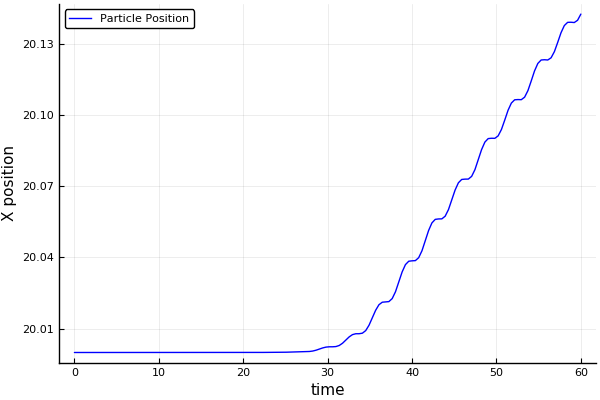

In [47]:
#Plot the answers
t_plot = (0:nsnap)*dt
plot(t_plot, part_x, c=:blue, label="Particle Position",xlab="time",ylab="X position")

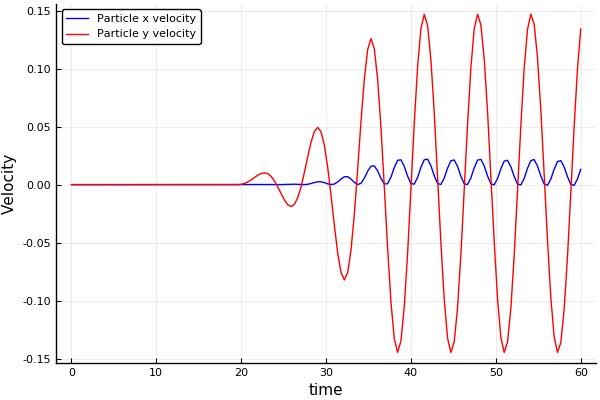

In [48]:
#Plot the answers
plot(t_plot, part_vx, c=:blue, label="Particle x velocity",xlab="time",ylab="Velocity")
plot!(t_plot, part_vy, c=:red, label="Particle y velocity")

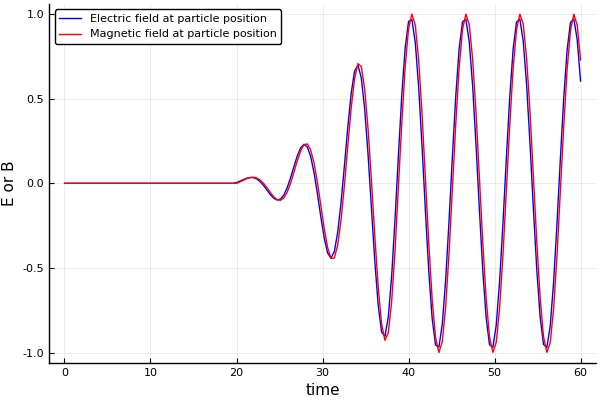

In [49]:
#Plot the answers
plot(t_plot, part_Ey, c=:blue, label="Electric field at particle position",xlab="time",ylab="E or B")
plot!(t_plot, part_Bz, c=:red, label="Magnetic field at particle position")

# Adding current

What we have described so far is actually a real type of code, called a "test particle code". Particles are moved in electric and magnetic fields but don't change the fields by their motion. To add this feedback, you simply add back in the current $\mathbf{J}$ term in Ampere's law. You then calculate the current by calculating $q \mathbf{v}$ for each particle and adding them together (this is another one of those things that no-one does but almost works).

At this point you have two problems.

### Particle to grid
The first and in some senses simplest problem is that the current is calculated at the particle position, but you want it on the grid with the E field in order to update Ampere's law. This is the reverse of the problem with getting the E and B fields to the particle location, and the solution is very similar. In fact, in order to get the right answer you can show that the function for moving data from the grid to the particle and the particle to the grid must be exact inverses of each other. This can be difficult to work out, especially with more complex functions, but conveniently the code tends to go very badly wrong if you do it incorrectly. (It sounds like I'm being sarcastic there, but there's nothing worse in computational physics than a subtle but important error. Something that fails dramatically and totally at least isn't leading you to do incorrect research.)

### Noise and convergence
This is the bigger problem. In a real code with current feedback on the fields, one particle is useless (even in a test particle code you generally want more than one particle just in case you put your one particle somewhere that gives an atypical answer). You would like to simulate every particle in your plasma, but that is effectively impossible - no computer even close to large enough to do that for any interesting plasma has yet been built. So you have to use a smaller number of particles and have each one "pretend" to represent a larger number of real particles. This isn't a bad model - particles that are near each other will tend to experience similar forces so will tend to wind up in similar places and assuming that they wind up in *exactly the same place* isn't untenable. But it is only a "tends to". If you don't have enough of these pseudoparticles then you can get a variety of problems.

  1. Your solution is noiser. Because of thermal fluctuations you only know the state of the plasma particles in a statistical way - there is inherant noise due to Brownian motion etc. In a PIC code this noise level is increased since you have fewer particles

  2. Nearby particles only "tend to" experience similar forces. If there's small scale physics that means that nearby particles *should* experience different forces you might miss it. You can improve this by increasing the resolution of your simulation grid (PIC codes obviously smooth forces over the scale of the grid because the $E$ and $B$ fields can't have structure smaller than the grid), and you can also increase the number of particles.

  3. The opposite problem. You can, by chance, have a particle that is in *just the right place to have something interesting happen to it*. In reality only a tiny number of particles would be in just that position, but because you are artificially linking them together you can get a massive overrepresentation of the effect. This can lead to you publishing an interesting result that doesn't actually happen. (This is very, very bad!)

The solution to all of these problems is what's termed *convergence testing*. Formally all of these integrators have the properties of consitency and convergence. That means that if you were to take an infinitely fine space grid, and infinitely short timesteps and an infinite number of particles (this is actually wrong because there are actually a finite number of real particles, but ignore this here) you will get the "right answer". That is it will give exactly the answer from the equations that we are modelling. You can't do that, but you can increase the resolution. If the answer only changes by an acceptable amount (what's acceptable is very subject dependent. You can tolerate a much bigger error in astrophysics than when you're building a particle accelerator) then you have much more confidence that your answer is right.

Take home message - **ALWAYS CONVERGENCE TEST!**

# Working PIC

So what can you do with an actual PIC code that's completed and working? Pretty much all of plasma physics (although you might need a very large computer to actually run it!). You can cover everything from basic plasma physics

<img src="img/TwoStream.png">

that's a picture of the electron two stream instability. You start with two populations of electrons propagating in a 1D domain. One set are going rightwards with constant speed, the other are going leftwards with constant speed. The instability means that they wind up with both populations going in both directions with a wide range of speeds.

<img src="img/EPOCH.jpg">

You can simulate a laser striking a solid target and boring a hole through it. A 3D simulation like this requires at least 100 computer processors to run in any reasonable time. The colours are the density of the plasma, you can see that just like the single particle above plasma is pulled through the target with the laser, being trapped in the troughs in the laser field.

They are also widely used in astrophysics (although they tend to produce rather less interesting graphs)